# 5 Fold Cross Validation on "Crypto-Gurus" Tweets using Logistic Regression, Support Vector Classifier and Multinomial Naive Bayes (Approach 1)

## 1) Import Packages

In [4]:
### BASIC PACKAGES
import pandas as pd
import numpy as np

### SKLEARN'S MACHINE LEARNING MODELS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

### METRICS CALCULATION
from sklearn import metrics

### SPACY'S STOP WORDS
from spacy.lang.en.stop_words import STOP_WORDS

### Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## 2) Defining the Machine Learner helper function for k-fold cross validation

In [11]:
# Pre-Processing:
# X = X or predictor variables, 1-D list or np.array
# y = y or target variables, 1-D list or np.array
# vect = CountVectorizer Text Preprocessor, needed for Text Analysis Machine Learning Model, CountVectorizer
# model = Machine Learning Model (E.g. Multinomial Naive Bayes, Linear SVC, LogisticRegression), sklearn ml model
# n_runs = Number of Runs to execute, int
# split_size = K fold Cross Validation, int
# seed = Random Generator Seed Value, int
# print_itr = condition to print the iterations 

# Post-Processing:
# index = Index Labels of the data in the form of iter{iteration int}_cv_split{cv_split int}, list of int
# full_buy_words = list of lists of top 10 words in predicting label: "Buy", list of list of str
# full_sell_words = list of lists of top 10 words in predicting label: "Sell", list of list of str
# full_train_aucs = List of Areas Under Curve in predicting Training set data, list of float
# full_test_aucs = List of Areas Under Curve in predicting Testing set data, list of float
# full_train_accs = List of Accuracy Scores in predicting Training set data, list of float
# full_test_accs = List of Accuracy Scores in predicting Testing set data, list of float
# full_train_null_accs = List of Null Accuracy Scores in predicting Training set data, list of float
# full_test_null_accs = List of Null Accuracy Scores in predicting Testing set data, list of float

def ml_cv(X, y, vect, model, n_runs, split_size, seed, print_itr):
    
    n_rows = len(y)
    np.random.seed(seed)

    ### RESULTS LISTS ###
    full_buy_words = []
    full_sell_words = []

    full_train_accs = []
    full_test_accs = []

    full_train_aucs = []
    full_test_aucs = []
    
    full_train_null_accs = []
    full_test_null_accs = []

    index = []
    
    classes = sorted(list(set(y)))
    all_pos_c0 = [a for a in range(len(y)) if y[a] == classes[0]]
    all_pos_c1 = [a for a in range(len(y)) if y[a] == classes[1]]
    
    n_c0 = len(all_pos_c0)
    n_c1 = len(all_pos_c1)
    
    cv_splits_c0 = [len(split_amts) for split_amts in np.array_split(list(range(n_c0)), split_size)]
    cv_splits_c1 = [len(split_amts) for split_amts in np.array_split(list(range(n_c1)), split_size)]
    
    for i in range(n_runs):
        if(print_itr):
            print("Run: {curr_run} out of {n_runs}".format(curr_run = i+1, n_runs = n_runs))
        
        all_pos = range(len(y))
        
        cv_set_pos_c0 = [a for a in range(len(y)) if y[a] == classes[0]]
        cv_set_pos_c1 = [a for a in range(len(y)) if y[a] == classes[1]]

        n_rows_c0 = len(all_pos_c0)
        n_rows_c1 = len(all_pos_c1)
        
        for cv in range(split_size):
            if(print_itr):
                print("Cross Validation: {curr_split} out of {split_size}".format(curr_split = cv + 1, split_size = split_size))
            
            if cv == split_size - 1:
                test_pos = cv_set_pos_c0 + cv_set_pos_c1
            else:
                test_pos_c0 = list(np.random.choice(cv_set_pos_c0, size = cv_splits_c0[cv], replace=False))
                test_pos_c1 = list(np.random.choice(cv_set_pos_c1, size = cv_splits_c1[cv], replace=False))
                test_pos = test_pos_c0 + test_pos_c1

            train_pos = list(set(all_pos) - set(test_pos))
            
            #print("train: ", train_pos, len(train_pos))
            #print("test: ", test_pos, len(test_pos))
            #print("Everything", list(set(train_pos + test_pos)), len(list(set(train_pos + test_pos))))
            
            X_train = [X[a] for a in train_pos]
            X_test = [X[a] for a in test_pos]
            y_train = [y[a] for a in train_pos]
            y_test = [y[a] for a in test_pos]

            cv_set_pos_c0 = list(set(cv_set_pos_c0) - set(test_pos_c0))
            cv_set_pos_c1 = list(set(cv_set_pos_c1) - set(test_pos_c1))

            #cv_vect2 = CountVectorizer(stop_words=STOP_WORDS)
            
            X_train_dtm = vect.fit_transform(X_train)
            X_test_dtm = vect.transform(X_test)

            #cv_lr2 = LogisticRegression()
            model.fit(X_train_dtm, y_train)
            
            # AREA UNDER CURVE SCORES
            if 'predict_proba' in dir(model):
                y_pred_test_prob = model.predict_proba(X_test_dtm)
                y_pred_train_prob = model.predict_proba(X_train_dtm)
                
                y_test_auc = metrics.roc_auc_score(y_score = [a[1] for a in y_pred_test_prob], y_true = y_test)
                y_train_auc = metrics.roc_auc_score(y_score = [a[1] for a in y_pred_train_prob], y_true = y_train)
            else:
                y_pred_test_prob = model.predict(X_test_dtm)
                y_pred_train_prob = model.predict(X_train_dtm)
                
                y_test_auc = metrics.roc_auc_score(y_score = y_pred_test_prob, y_true = y_test)
                y_train_auc = metrics.roc_auc_score(y_score = y_pred_train_prob, y_true = y_train)

            full_train_aucs.append(y_train_auc)
            full_test_aucs.append(y_test_auc)
            
            # PREDICTION ACCURACY SCORES
            y_pred_test_class = model.predict(X_test_dtm)
            y_pred_train_class = model.predict(X_train_dtm)
            
            train_acc_score = metrics.accuracy_score(y_pred=y_pred_train_class, y_true=y_train)
            test_acc_score = metrics.accuracy_score(y_pred=y_pred_test_class, y_true=y_test)
            
            full_train_accs.append(train_acc_score)
            full_test_accs.append(test_acc_score)
            
            # NULL ACCURACY SCORES
            train_classes = list(np.unique(y_train))
            test_classes = list(np.unique(y_test))
            
            train_most_occur_class = train_classes[1] if len([a for a in y_train if a == train_classes[1]])/len(y_train) >= 0.5 else train_classes[0]
            test_most_occur_class = test_classes[1] if len([a for a in y_test if a == test_classes[1]])/len(y_test) >= 0.5 else test_classes[0]
            
            train_null_acc = sum([1 for a in y_train if a == train_most_occur_class])/len(y_train)
            test_null_acc = sum([1 for a in y_test if a == test_most_occur_class])/len(y_test)
            
            full_train_null_accs.append(train_null_acc)
            full_test_null_accs.append(test_null_acc)
            
            # TOP 10 BUY AND SELL WORD PREDICTORS
            df = pd.DataFrame({'coef': model.coef_[0], 'word': vect.get_feature_names()})
            buy_words_df = df.sort_values('coef', ascending=False)
            sell_words_df = df.sort_values('coef', ascending=True)
            buy_words = list(buy_words_df.word[:10])
            sell_words = list(sell_words_df.word[:10])

            full_buy_words.append(buy_words)
            full_sell_words.append(sell_words)
            
            # ITERATION AND SPLIT AS INDEXES
            curr_index = "iter{itr}_cv_split{cv_split}".format(itr = i + 1, cv_split = cv + 1)
            index.append(curr_index)
            
    return index, full_buy_words, full_sell_words, full_train_aucs, full_test_aucs, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs


## 3) Main Code

Runs 3 models: Logistic Regression, Support Vector Classifier and Multinomial Naive Bayes <br>
Number of Iterations: 100 <br>
K-Fold Cross Validation: 5 <br>
Results are saved into the results folder and segmented by tweeter

In [12]:
### MAIN
all_tweets = pd.read_csv('all_tweets_data.csv')
all_users = all_tweets.user.unique()

### Iterate for all user's tweets with the exception for user 1 because he does not have a sell signal
RES_FOLDER_PATH = "twt user results app1"

### MODELS DICTIONARY
lr = LogisticRegression()
svc = LinearSVC()
nb = MultinomialNB()

model_dict = {
    'LogReg': lr,
    'LinSVC': svc,
    'MultiNB': nb
}

for user_pos in range(1, len(all_users)):
    user = all_tweets.user.unique()[user_pos]
    print(user)
    user_df = all_tweets[(all_tweets.user == user) & (all_tweets['Buy/Neutral/Sell'] != 0)]
    
    X = list(user_df.new_tweets)
    y = list(user_df['Buy/Neutral/Sell'])
    
    for model_name in model_dict.keys():
        print(model_name)
        vect = CountVectorizer(stop_words=STOP_WORDS)
        model = model_dict[model_name]
        n_runs = 100
        split_size = 5
        seed = 4222
        print_itr = False

        index, full_buy_words, full_sell_words, full_train_aucs, full_test_aucs, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs = ml_cv(X, y, vect, model, n_runs, split_size, seed, print_itr)

        df_full_buy_words = pd.DataFrame(full_buy_words, index = index)
        df_full_buy_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_buy_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))

        df_full_sell_words = pd.DataFrame(full_sell_words, index = index)
        df_full_sell_words.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_sell_words.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))

        df_full_scores = pd.DataFrame({'full_train_aucs': full_train_aucs,
                                          'full_test_aucs': full_test_aucs,
                                          'full_train_accs': full_train_accs,
                                          'full_train_null_accs': full_train_null_accs,
                                          'full_test_accs': full_test_accs, 
                                          'full_test_null_accs': full_test_null_accs}, index = index)

        df_full_scores.to_csv("./{RES_FOLDER_PATH}/{user}/{model_name}_full_scores.csv".format(RES_FOLDER_PATH = RES_FOLDER_PATH, user = user, model_name = model_name))

CryptoYoda1338
LogReg
LinSVC
MultiNB
ZeusZissou
LogReg
LinSVC
MultiNB
anbessa100
LogReg
LinSVC
MultiNB
cryptousemaki
LogReg
LinSVC
MultiNB


## 4) Visualization

We look at the performance of the 3 models by evaluating the box plots of the accuracy scores from the test sets and the Area Under Curve scores from the test sets.

In [15]:
# READ ALL THE DATA
model_names = ['LogReg', 'LinSVC', 'MultiNB']

res_dict = {}

RES_FOLDER_PATH = "twt user results app1"

# Get all the scoring results
for model_name in model_names:
    mod_dict = {}
    for user in all_users[1:len(all_users)]:
        path = "./{folder_path}/{user}/{model_name}_full_scores.csv".format(folder_path = RES_FOLDER_PATH, user = user, model_name = model_name)
        res = pd.read_csv(path, index_col=0)
        mod_dict[user] = res
    res_dict[model_name] = mod_dict

In [16]:
# Types of Scores from the data
res_types = res_dict[model_name][user].columns
res_types

Index(['full_test_accs', 'full_test_aucs', 'full_test_null_accs',
       'full_train_accs', 'full_train_aucs', 'full_train_null_accs'],
      dtype='object')

In [17]:
### helper function to extract all of the possible info
def get_model_all_user_scores(mod_dict, res_type):
    all_user_scores_dict = {}
    for user in mod_dict.keys():
        all_user_scores_dict[user] = mod_dict[user][res_type]
    
    df_all_user_scores = pd.DataFrame(all_user_scores_dict)
    
    return df_all_user_scores

### Combine scores of all users and models
def get_all_scores(res_dict, res_type):
    df_res = pd.DataFrame()
    for model in res_dict.keys():
        df_model = get_model_all_user_scores(res_dict[model], res_type)
        df_model = df_model.reset_index()
        df_model['model'] = pd.Series([model] * len(df_model))
        df_res = df_res.append(df_model)
    df_res = df_res.reset_index()
    df_res = df_res.drop('level_0', axis = 1)
    return df_res

### 4a) Test Accuracy Scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002234FE7FB00>,
      dtype=object)

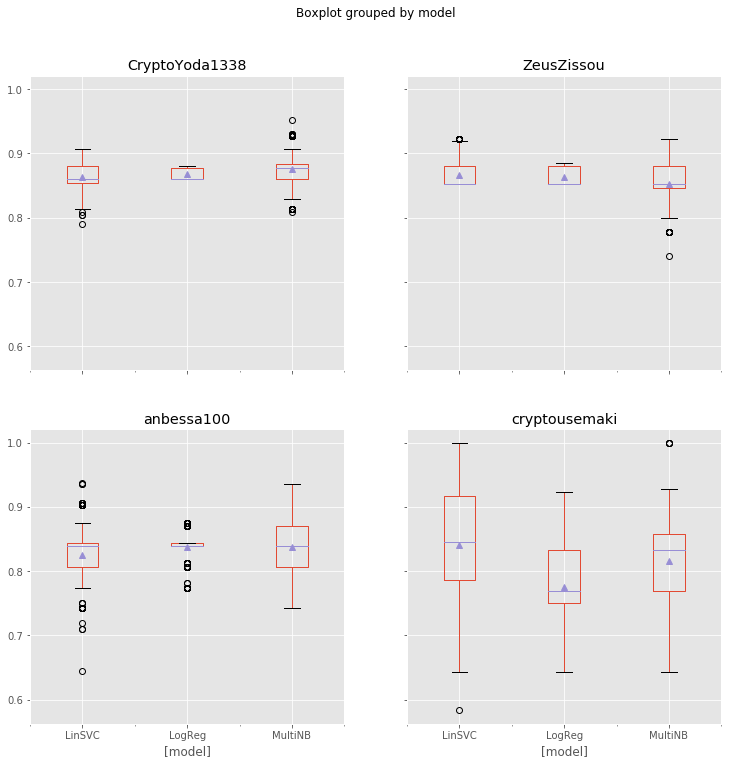

In [18]:
df_acc_res = get_all_scores(res_dict, 'full_test_accs')
df_acc_res.boxplot(by='model', figsize=(12,12), showmeans = True)

### 4b) Test AUC Scores

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002234FE71C50>,
      dtype=object)

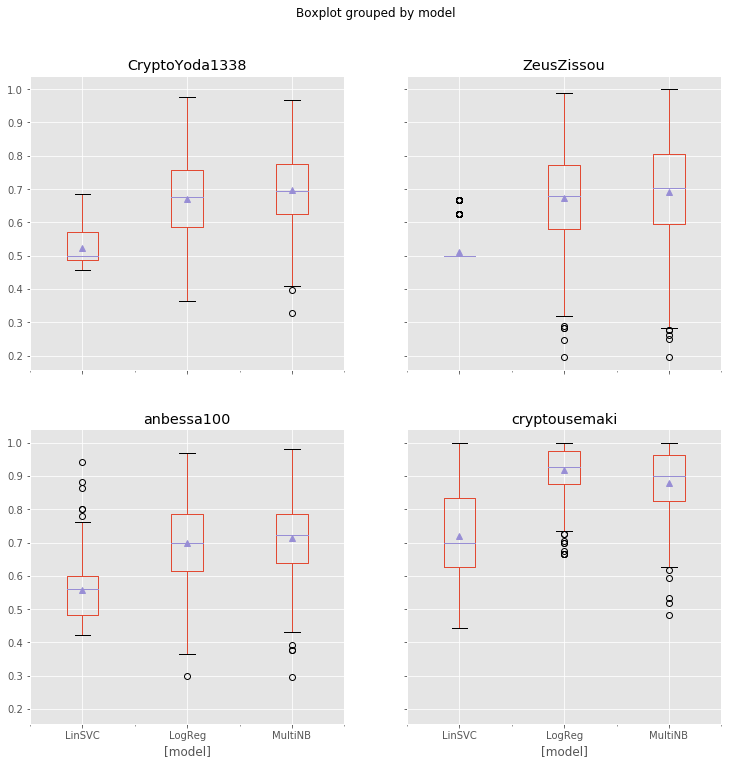

In [19]:
df_auc_res = get_all_scores(res_dict, 'full_test_aucs')
df_auc_res.boxplot(by='model', figsize=(12,12), showmeans = True)

### 4c) Information Gain

Taking the difference between the null accuracy and prediction accuracy scores to find out if the model has created some learning ability in classify tweets into a buy and sell signal.

In [20]:
df_null_res = get_all_scores(res_dict, 'full_test_null_accs')

dict_res_test_ig = {}
dict_res_test_ig['model'] = df_acc_res['model']
for user in all_users[1:5]:
    test_ig = [df_acc_res[user][pos] - df_null_res[user][pos] for pos in range(len(df_acc_res))]
    dict_res_test_ig[user] = test_ig

df_test_ig = pd.DataFrame(dict_res_test_ig)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002234FE49208>,
      dtype=object)

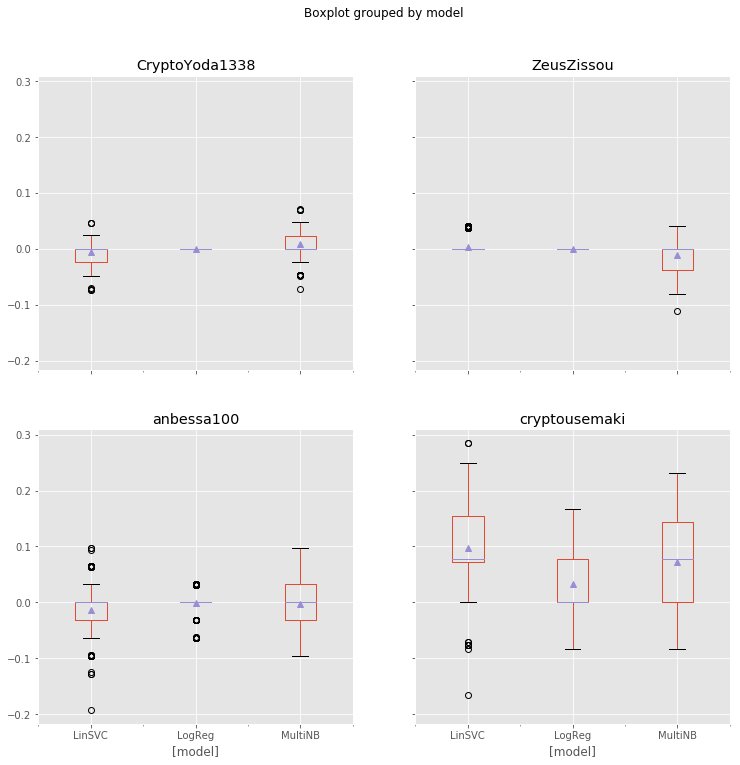

In [21]:
df_test_ig.boxplot(by='model', figsize=(12,12), showmeans = True)

## Appendix A

This is a testing playground

In [ ]:
twters = all_tweets['user'].unique()
twt_user = all_tweets[(all_tweets.user == twters[2]) & (all_tweets['Buy/Neutral/Sell'] != 0)]
X = list(twt_user.new_tweets)
y = list(twt_user['Buy/Neutral/Sell'])
vect = CountVectorizer(stop_words=STOP_WORDS)
model = LogisticRegression()
n_runs = 100
split_size = 5
seed = 4222
print_itr = False
index, full_buy_words, full_sell_words, full_train_aucs, full_test_aucs, full_train_accs, full_test_accs, full_test_null_accs, full_train_null_accs = ml_cv(X, y, vect, model, n_runs, split_size, seed, print_itr)


In [ ]:
a = np.reshape(full_test_accs, (100,5))
b = [np.mean(c) for c in a]
b

x = list(range(len(b)))
y = b
plt.plot(x, y)
plt.title("100 Iterations of 5-Fold Cross Validation with Logistic Regression, Test Set Accuracy Score")
plt.xlabel("Number of Runs")
plt.ylabel("Test Accuracy Score")
#[xmin, xmax, ymin, ymax]
plt.axis([np.min(x)- 5, np.max(x) + 5, np.min(y) - 3*np.std(y), np.max(y) + 3*np.std(y)])
plt.show()

print('Min Test Accuracy Score:  {min_test_acc_score}'.format(min_test_acc_score = round(np.min(b), 10)))
print('Max Test Accuracy Score:  {max_test_acc_score}'.format(max_test_acc_score = round(np.max(b), 10)))
print('Mean Test Accuracy Score: {mean_test_acc_score}'.format(mean_test_acc_score = round(np.mean(b), 10)))
print('Std Test Accuracy Score:  {std_test_acc_score}'.format(std_test_acc_score = round(np.std(b), 10)))

In [ ]:
plt.boxplot([y,y], showmeans=True)
plt.show()

t1) Getting data into proper dataframes

In [18]:
wc = WordCloud()
full_buy_words

[['buying',
  'buy',
  'amp',
  'daily',
  'good',
  'level',
  'fomo',
  'coin',
  'stoch',
  'entry'],
 ['buying',
  'buy',
  'bought',
  'level',
  'coin',
  'daily',
  'time',
  'stoch',
  'amp',
  'rsi'],
 ['buy',
  'buying',
  'coin',
  'daily',
  'rsi',
  'bought',
  'good',
  'stoch',
  'levels',
  'target'],
 ['buying',
  'buy',
  'stoch',
  'rsi',
  'time',
  'daily',
  'line',
  'masternode',
  'fib',
  'breakout'],
 ['buying',
  'buy',
  'bought',
  'coin',
  'rsi',
  'level',
  'amp',
  'good',
  'stoch',
  'fib'],
 ['buying',
  'buy',
  'daily',
  'time',
  'stoch',
  'coin',
  'rsi',
  'entry',
  'bought',
  'order'],
 ['buying',
  'buy',
  'rsi',
  'stoch',
  'bought',
  'amp',
  'good',
  'line',
  'fib',
  'coin'],
 ['buy',
  'buying',
  'daily',
  'coin',
  'stoch',
  'good',
  'bought',
  'rsi',
  'levels',
  'target'],
 ['buying',
  'buy',
  'bought',
  'coin',
  'time',
  'daily',
  'amp',
  'level',
  'looks',
  'masternode'],
 ['buying',
  'buy',
  'daily',
  'r

In [11]:
from nltk.stem.snowball import SnowballStemmer

In [12]:
stemmer = SnowballStemmer("english")

In [28]:
for twt in user_df['new_tweets']:
    stem_words = [stemmer.stem(word) for word in twt.split(" ")]
    new_sentence = stem_words[0]
    for word in stem_words[1:]:
        new_sentence = new_sentence + " " + word
    print(new_sentence)

didn't like min ichimoku resist sold better safe than sorri can't sleep otherwis
got a bad feel set a stop loss on break even
ok i got fill let bounc
i need a final stop run to get fill
also it below ema so i believ it a good buy if we don't close the day below ema
start buy good volum touch the support wait for confirm
bullish on usdbtc
chart ethbtc buy ethusd
rebuy when you see bitcoin is the worst invest ever line on tv
buy philip smartsleep the second it hit the market
revers incom
we are abov the daili cloud sinc foreverif price fall under cloud rektfest
when it dump after you got stop out
stop
bought fib level in anticip to breakout set a tight stop amp wait for
slowli fall into buyzon buy purpl boxtrad trx on binanc gt
s disgrac made me bullish
prepar for moon bought yellow lineorigin analysi from short term target abov daili cloud
set stop as price move higher exampl differ approach ofc availablelet your winner ride cut your loss short
black friday discount on everi alt
buy fre